# Primal Dual to solve Discrete Optimal Transport

<div class="alert alert-block alert-success">
    
This notebook we aim at solving DOT instances using modern optimisation algorithms that outperform the simplex method. To do this we will use the Primal Dual framework. 
    
The notebook is divided in three parts. First, Condat's projection into the ℓ<sub>1</sub> ball algorithm is implemented. Second, the algorithm is used to find feasible solutions of DOT. Finally, the Primal Dual algorithm is tested. The results are automatically stored with an unique identifier and some performance plots are presented.
</div>

* Laurent Condat. <i>Fast projection onto the simplex and the ℓ<sub>1</sub> ball</i>. Math. Program. 158, 575–585 (2016). [https://doi.org/10.1007/s10107-015-0946-6](https://doi.org/10.1007/s10107-015-0946-6). _Also available at_ [https://hal.archives-ouvertes.fr/hal-01056171v2](https://hal.archives-ouvertes.fr/hal-01056171v2).



* V ̃u, B. (2011). <i>A splitting algorithm for dual monotone inclusions involving cocoercive operators </i>. Adv. Comput. Math, pages 667–681. [https://doi.org/10.1007/s10444-011-9254-8](https://doi.org/10.1007/s10444-011-9254-8).

<div class="alert alert-block alert-info">
Packages
</div>

In [1]:
import numpy  as np
import pandas as pd
import time
import os
import matplotlib.pyplot as plt

# Particular functions
from numpy import zeros, zeros_like, allclose, where, ones, inf, absolute, linspace, tile, maximum, minimum, subtract
from numpy.random import default_rng as rng
from numba import jit
from scipy.spatial.distance import cdist
from scipy.linalg import norm

# Algorithm

Now, we will run the Primal Dual algorithm addapted for DOT. To test it, we will run it against some of the DOTMark files. We will aim to transport from one given image to another, which are normalised and flattened in ```C```-order. The matrix of costs is based on a uniform grid within $[0,1]^2$ with $M$ points for the source and $N$ points for the target.

## Instance information

In [2]:
folder = 'Microscopy_Sized'
path = 'Exact/' + folder + '/'

In [3]:
files = [f[:-9] for f in os.listdir(path) if f.endswith('.txt')]
print('There are', len(files), 'instances in this location:')
display(files)

There are 4 instances in this location:


['data16_1002-data16_1010_p=S2',
 'data8_1002-data8_1010_p=S2',
 'data32_1002-data32_1010_p=S2',
 'data64_1002-data64_1010_p=S2']

Select one instance:

In [4]:
instance = files[1]
full_path = path + instance

Load data:

In [5]:
m = np.load(full_path + '_m.npy');    M = m.size
n = np.load(full_path + '_n.npy');    N = n.size
c = np.load(full_path + '_Cost.npy')
sol = np.load(full_path + '_Sol.npy')

In [6]:
with open(full_path + '_Time.txt', 'r') as f:
    obj_exact = eval((f.readlines())[0])['Obj']

## Run algorithm

<div class="alert alert-block alert-warning">
    
In what follows, we provide tests for the chosen instance running the Primal Dual approach given by Bằng Công Vũ (2011).
    
    
* V ̃u, B. (2011). <i>A splitting algorithm for dual monotone inclusions involving cocoercive operators </i>. Adv. Comput. Math, pages 667–681. [https://doi.org/10.1007/s10444-011-9254-8](https://doi.org/10.1007/s10444-011-9254-8).
</div>

\begin{align}
    \mathrm{prox}_{\sigma f^*} (u) &= u - \sigma \mathrm{prox}_{\sigma^{-1} f} ( u/\sigma )
    \\
    &= u - \sigma [ u/\sigma - 1/\sigma ]_+
\end{align}

In [7]:
def primal_dual_improved(c,m,n,iters, collect_obj = False, true_obj = None, true_obj_tol = 1e-4, true_solution = None, save_iter = False):
    #Algorithm for calculating solution x, in the primal space
    #and y_1, y_2 in the dual space.
    #Also returns the value of the objective function c*x at each
    #iteration.
    
    '''
        Initialise parameters
    '''
    #Initialise τ
    τ = 1e-3 * 1.9
    
    #Initialise σ
    σ = 1.0/τ - 1e-5
    
    
    #Initialise β
    β = σ/τ
    β_sqrt = np.sqrt(β)
    
    #Initialise ρ
    ρ = 1.9 #- 1e-4 # this helped in 8x8 but not for bigger colour instances
    
    #Initialise δ
    δ = 0.9
    
    #Initialise μ
    μ = 0.9
    
    #Initialise θ
    θ = 1
    
    #fetch lengths of m and n.
    N = n.size
    M = m.size
    
    print('\n*** Primal Dual with M = {}, N = {}, MN = {} ***\n\n'.format(M,N,M*N))
    
    
    '''
        Initialise matrices
    '''
    #Initialise x & y
    x, y = zeros((2,M,N));            #y[0,:] = n;    y[:,0] = m
    #Initialise xₖ, yₖ, xₚ
    xₖ, yₖ, xₚ = zeros((3,M,N))
    
    '''
        Information from true solution (if available)
    '''
    # Store current objective value
    if collect_obj == True:
        obj = [(c*x).sum()]
    
    # Norm of true solution
    if true_solution is not None:
        true_obj_crit = 1.0
        if true_obj is None:
            true_obj = (c*sol).sum()
        print('Objective from ground truth:', obj_exact,'\n')
        
    '''
        Iterate the Primal Dual scheme
    '''
    
    every_iter = {
        'it':[], 'obj':[], 'dist_obj':[], 'time':[], 'dist_x':[], 'rel_var':[], 
        'hyperₘ':{'L2': [], 'max': [], 'min':[]}, 'hyperₙ':{'L2': [], 'max': [], 'min':[]}
                 }
    every_critical = {'it':[], 'obj':[], 'tol':[], 'dist_obj':[], 'time':[], 'dist_x':[]}
    
    if true_solution is not None:
        print('     It  |  Tolerance |        Time       | Frob. dist. ')
        print( '{:-^55}'.format('') )
        
    timed = 0.0
    
    
    for k in range(iters):
        
        it_time = time.time()
        
        p = x - τ * (c * y)
        
        # Projection step for g
        κₘ = p.sum(1) - m
        κₙ = p.sum(0) - n

        βₘ = κₘ.sum() / (M + N)        # dim M
        βₙ = κₙ.sum() / (M + N)        # dim N
        
        # Implicit yₖ = ( (κₘ - βₘ)/N).reshape(M,1) + (κₙ - βₙ)/M
        ψ = (1.0/N) * (κₘ - βₘ)
        ϕ = (1.0/M) * (κₙ - βₙ)
        
        # Projection: p = p - yₖ
        # p -= ( tile( (κₘ - βₘ)/N, (N,1)).T + tile( (κₙ - βₙ)/M, (M,1)) )
        subtract(p, ϕ, out=p);     subtract(p, ψ.reshape(M,1), out=p)
        
        
        τnew = (τ + τ*np.sqrt(1 + θ))/2
        while (0<1):
            
            θ = τnew/τ
            x̄ = p + θ*(p - x)
            
            ỹ = y + (β*τnew) * c * x̄
            yₙ = minimum(ỹ - 1, 0) + 1
                        
            if (β_sqrt*τnew*norm(c*(yₙ - y))<δ*norm(yₙ-y)):
                break
                
            τnew = μ*τnew
        
        
        τ = τnew
        x = p
        y = yₙ
        
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time
        
        # Update objective function
        if collect_obj == True:
            obj.append( (c*x).sum() )
            # Compute relative objective distance
            if true_solution is not None:
                dist_true_sol = abs(obj[-1] - true_obj)/true_obj
        
        # If all iterations are to be stored:
        if save_iter == True:
            frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
            r, s   = x.sum(1) - m, x.sum(0) - n
            
            every_iter['it'].append( k )
            every_iter['obj'].append( (c*x).sum() )
            every_iter['dist_obj'].append( dist_true_sol if true_obj is not None else np.nan )
            every_iter['time'].append( timed )
            every_iter['dist_x'].append( frob_d )
            every_iter['rel_var'].append( norm(xₚ-x, 'fro')/norm(x, 'fro') if not allclose(x,0) else np.nan )
            # Constrained satisfactibility
            every_iter['hyperₘ']['L2'].append( norm(r)/norm(m) )
            every_iter['hyperₘ']['max'].append( abs(r/maximum(m,1e-7)).max() )
            every_iter['hyperₘ']['min'].append( abs(r/maximum(m,1e-7)).min() )
            every_iter['hyperₙ']['L2'].append( norm(s)/norm(n) )
            every_iter['hyperₙ']['max'].append( abs(s/maximum(n,1e-7)).max() )
            every_iter['hyperₙ']['min'].append( abs(s/maximum(n,1e-7)).min() )
            
        # If a true solution is available, we check the tolerance:
        if true_solution is not None: 
            if dist_true_sol < true_obj_crit:
                frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
                
                every_critical['it'].append( k )
                every_critical['obj'].append( obj[-1] )
                every_critical['tol'].append( true_obj_crit )
                every_critical['dist_obj'].append( dist_true_sol )
                every_critical['time'].append( timed )
                every_critical['dist_x'].append( frob_d )
                
                print('* {0:6.0f} |    {1:.1e} | {2:15.2f} s |    {3:4.4f}'.format(k,true_obj_crit,
                                                                                   timed,frob_d))
                
                # If the prescribed tolerance is reached, we finish.
                if dist_true_sol < true_obj_tol:
                    print('Solution found with given tolerance.')
                    break
                
                # Adjust current level of inner tolerance
                true_obj_crit *= 0.1
        
        # Update previous step
        xₚ = x.copy()
                
    if true_solution is not None:
        print( '{:-^55}'.format('') )
        
    print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(timed,k))
    
    
    if collect_obj == False and save_iter == True:
        return x, every_iter
    if collect_obj == True and save_iter == True:
        return x, obj, every_critical, every_iter
    else:
        return x

In [8]:
x, obj, every_critical, every_iter = primal_dual_improved(c,m,n, 100000, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-7, true_solution = sol, save_iter = True)


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  |  Tolerance |        Time       | Frob. dist. 
-------------------------------------------------------
*     22 |    1.0e+00 |            0.01 s |    0.8952
*     43 |    1.0e-01 |            0.01 s |    0.8421
*     57 |    1.0e-02 |            0.02 s |    0.8155
*    870 |    1.0e-03 |            0.11 s |    0.4616
*   3043 |    1.0e-04 |            0.36 s |    0.5210
*   3050 |    1.0e-05 |            0.36 s |    0.5218
-------------------------------------------------------

Algorithm stopped after 11.5041 seconds and 99999 iterations


In [9]:
print('Average time per iteration:',every_iter['time'][-1]/len(every_iter['time']))

Average time per iteration: 0.00011504117250442505


## Visualise and store results

In [10]:
main_folder = folder + '_Results'
out_folder  = main_folder + '/' + instance
algorithm   = 'PD_Improved-'

In [11]:
# Check if main folder for results exists, else create it
if not os.path.exists(main_folder):    os.makedirs(main_folder)
# Now create a folder for the results of the instance
if not os.path.exists(out_folder):    os.makedirs(out_folder)
out_folder += '/' + algorithm

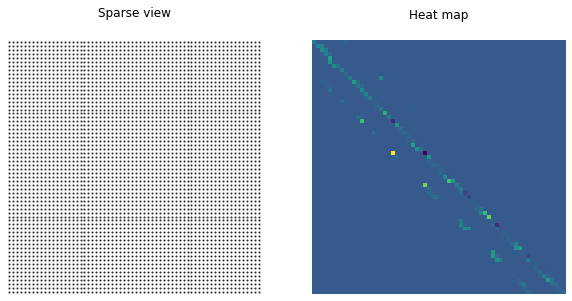

In [12]:
# Visualise solution
plt.figure(figsize = (10,5))

plt.subplot(1, 2, 1)
plt.spy(x, markersize=1, aspect = 1, markeredgecolor = 'black', alpha=0.75);    plt.axis('off')
plt.title('Sparse view')
plt.subplot(1, 2, 2)
plt.imshow(x);    plt.axis('off');    plt.title('Heat map\n')

plt.savefig(out_folder+'Sparse-Heat.pdf', bbox_inches='tight',transparent=True)
plt.show()

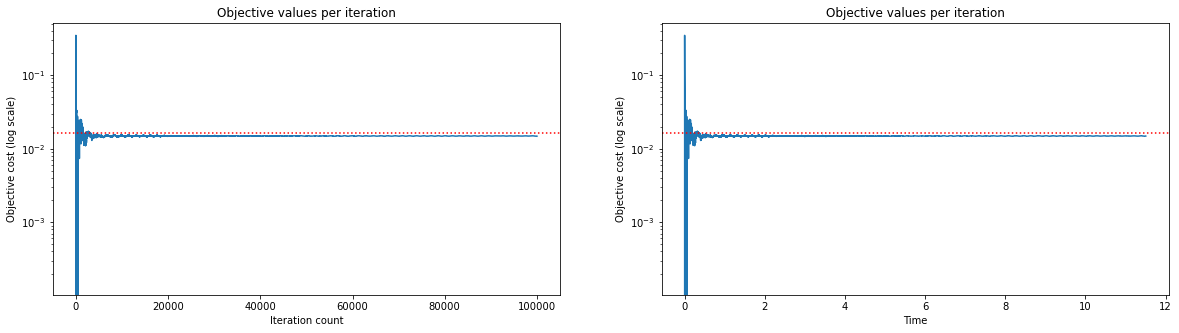

In [13]:
# Visualise evolution of objective values
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(obj)
plt.axhline(y=obj_exact, color='r', linestyle=':')
plt.yscale('log');    plt.title('Objective values per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Objective cost (log scale)')
plt.subplot(1, 2, 2)
plt.plot(np.append([0], every_iter['time']),obj)
plt.axhline(y=obj_exact, color='r', linestyle=':')
plt.yscale('log')
plt.title('Objective values per iteration')
plt.xlabel('Time');    plt.ylabel('Objective cost (log scale)')

plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.show()

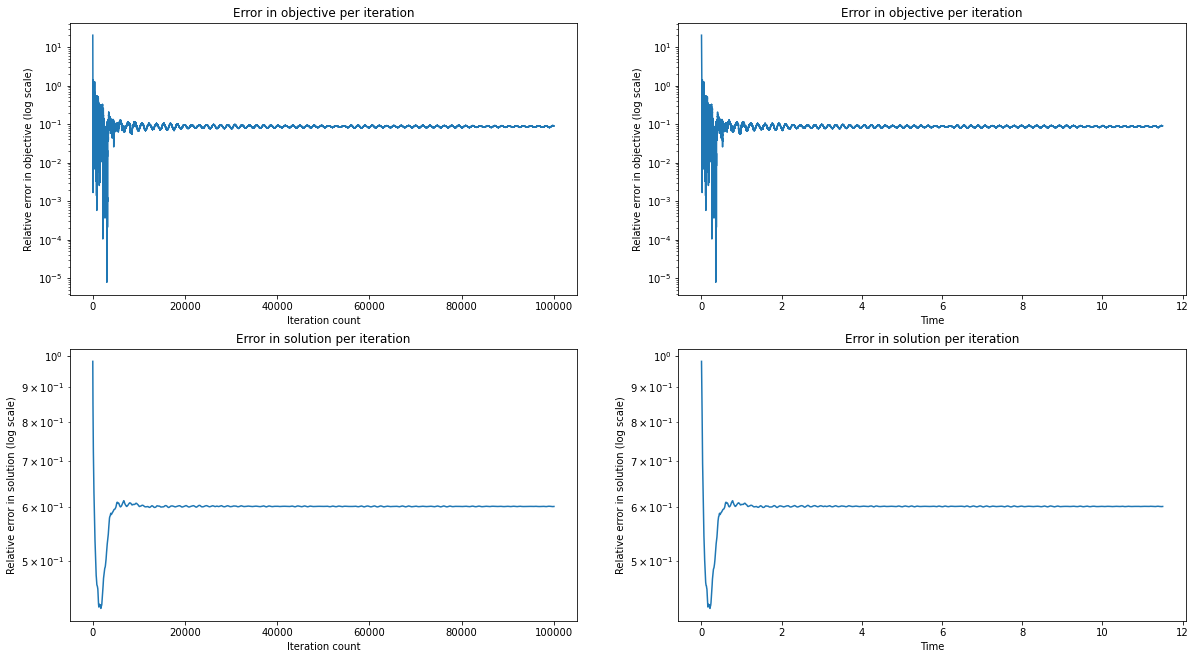

In [14]:
# Visualise evolution of relative errors
plt.figure(figsize = (20,11))

plt.subplot(2, 2, 1)
plt.plot(every_iter['dist_obj'])
plt.yscale('log')
plt.title('Error in objective per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Relative error in objective (log scale)')
plt.subplot(2, 2, 2)
plt.plot(every_iter['time'],every_iter['dist_obj'])
plt.yscale('log')
plt.title('Error in objective per iteration')
plt.xlabel('Time');    plt.ylabel('Relative error in objective (log scale)')
plt.subplot(2, 2, 3)
plt.plot(every_iter['dist_x'])
plt.yscale('log')
plt.title('Error in solution per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Relative error in solution (log scale)')
plt.subplot(2, 2, 4)
plt.plot(every_iter['time'],every_iter['dist_x'])
plt.yscale('log')
plt.title('Error in solution per iteration')
plt.xlabel('Time');    plt.ylabel('Relative error in solution (log scale)')

plt.savefig(out_folder+'Rel_Error.pdf', bbox_inches='tight',transparent=True)
plt.show()

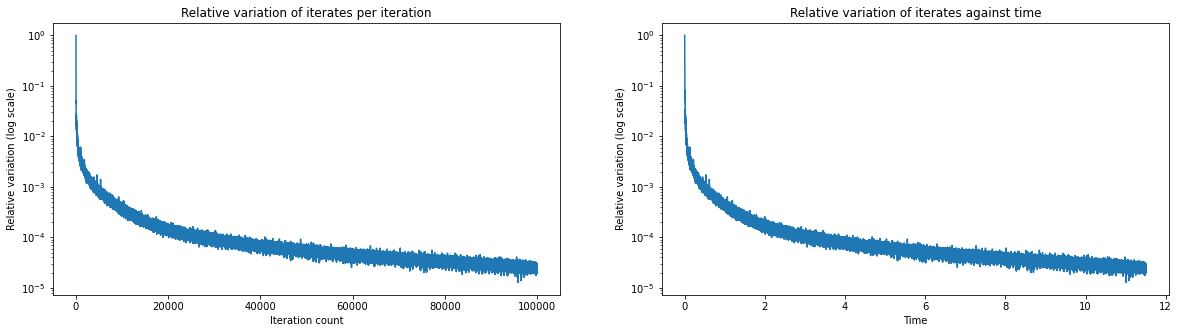

In [15]:
# Relative variation
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['it'], every_iter['rel_var'])
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative variation (log scale)');
plt.title('Relative variation of iterates per iteration')

plt.subplot(1, 2, 2)
plt.plot(every_iter['time'], every_iter['rel_var'])
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative variation (log scale)');
plt.title('Relative variation of iterates against time')

plt.savefig(out_folder+'Relative_Var.pdf', bbox_inches='tight',transparent=True)
plt.show()

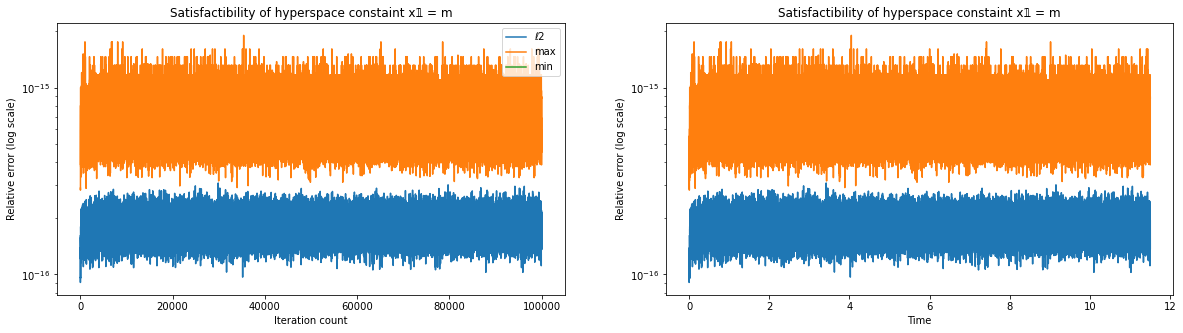

In [16]:
# Relative variation for x𝟙 = m
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['it'], every_iter['hyperₘ']['L2'], label='ℓ2')
plt.plot(every_iter['it'], every_iter['hyperₘ']['max'], label='max')
plt.plot(every_iter['it'], every_iter['hyperₘ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint x𝟙 = m')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(every_iter['time'], every_iter['hyperₘ']['L2'], label='ℓ2')
plt.plot(every_iter['time'], every_iter['hyperₘ']['max'], label='max')
plt.plot(every_iter['time'], every_iter['hyperₘ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint x𝟙 = m')

plt.savefig(out_folder+'RelE_m.pdf', bbox_inches='tight',transparent=True)
plt.show()

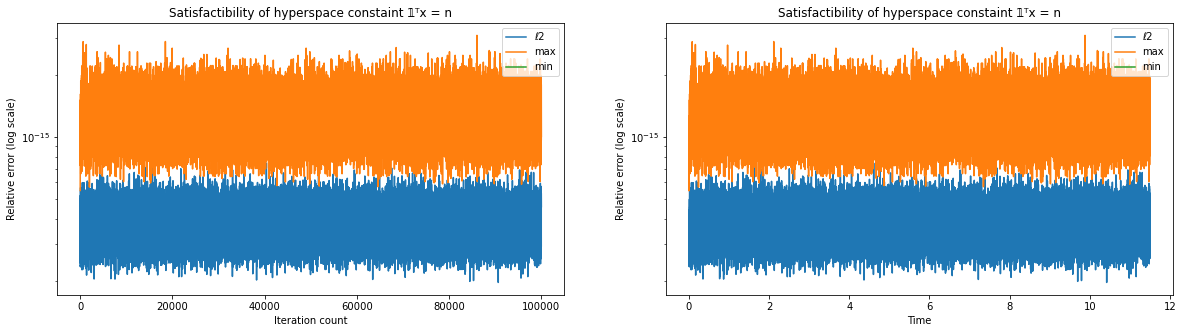

In [17]:
# Relative variation for 𝟙ᵀx = n
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['it'], every_iter['hyperₙ']['L2'], label='ℓ2')
plt.plot(every_iter['it'], every_iter['hyperₙ']['max'], label='max')
plt.plot(every_iter['it'], every_iter['hyperₙ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint 𝟙ᵀx = n');    plt.legend()

plt.subplot(1, 2, 2)
plt.plot(every_iter['time'], every_iter['hyperₙ']['L2'], label='ℓ2')
plt.plot(every_iter['time'], every_iter['hyperₙ']['max'], label='max')
plt.plot(every_iter['time'], every_iter['hyperₙ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint 𝟙ᵀx = n');    plt.legend()

plt.savefig(out_folder+'RelE_n.pdf', bbox_inches='tight',transparent=True)
plt.show()

All the data from the above two plots is also available as dataframes:

In [18]:
df_critical = pd.DataFrame.from_dict(every_critical)
df_critical.to_pickle(out_folder+'Critical.pkl') # To read back use pd.read_pickle(file_name)
df_critical.to_excel(out_folder+'Critical.xlsx')
display(df_critical)

# If we want this table in LaTeX format run:
print(df_critical.to_latex(index=False))

,it,obj,tol,dist_obj,time,dist_x
0,15,0.032422,1.0000,0.992519,0.011303,0.897292
1,29,0.016846,0.1000,0.035304,0.020018,0.826097
2,39,0.016383,0.0100,0.006854,0.028094,0.803932
3,4634,0.016264,0.0010,0.000470,2.367314,0.885163
4,6768,0.016273,0.0001,0.000090,3.380030,0.886269


\begin{tabular}{rrrrrr}
\toprule
   it &       obj &     tol &  dist\_obj &      time &    dist\_x \\
\midrule
   15 &  0.032422 &  1.0000 &  0.992519 &  0.011303 &  0.897292 \\
   29 &  0.016846 &  0.1000 &  0.035304 &  0.020018 &  0.826097 \\
   39 &  0.016383 &  0.0100 &  0.006854 &  0.028094 &  0.803932 \\
 4634 &  0.016264 &  0.0010 &  0.000470 &  2.367314 &  0.885163 \\
 6768 &  0.016273 &  0.0001 &  0.000090 &  3.380030 &  0.886269 \\
\bottomrule
\end{tabular}



In [19]:
#df_every = pd.DataFrame.from_dict(every_iter)
df_every = pd.concat([
                pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['hyperₘ', 'hyperₙ'] } ),
                pd.DataFrame.from_dict( {'hyperₘ-'+a:b for a,b in every_iter['hyperₘ'].items()} ), 
                pd.DataFrame.from_dict( {'hyperₙ-'+a:b for a,b in every_iter['hyperₙ'].items()} )], axis = 1)
df_every.to_pickle(out_folder+'Every.pkl') # To read back use pd.read_pickle(file_name)
df_every.to_excel(out_folder+'Every.xlsx')
display(df_every.head())

,it,obj,dist_obj,time,dist_x,rel_var,hyperₘ-L2,hyperₘ-max,hyperₘ-min,hyperₙ-L2,hyperₙ-max,hyperₙ-min
0,0,0.347521,20.357201,0.001209,0.980901,1.000000,9.618326e-17,2.897743e-16,0.0,2.373414e-16,5.479524e-16,0.0
1,1,0.279942,16.204096,0.001976,0.974332,0.295412,1.273265e-16,4.467211e-16,0.0,3.186550e-16,7.634994e-16,0.0
2,2,0.199809,11.279461,0.002593,0.967507,0.300794,8.391864e-17,4.181171e-16,0.0,2.879801e-16,9.611141e-16,0.0
3,3,0.135807,7.346120,0.003260,0.961293,0.254096,9.740428e-17,4.751374e-16,0.0,2.988552e-16,7.056425e-16,0.0
4,4,0.093058,4.718947,0.003876,0.955353,0.222975,1.017027e-16,4.017656e-16,0.0,2.913069e-16,9.045111e-16,0.0


In [20]:
df_every.describe()

,it,obj,dist_obj,time,dist_x,rel_var,hyperₘ-L2,hyperₘ-max,hyperₘ-min,hyperₙ-L2,hyperₙ-max,hyperₙ-min
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05
mean,49999.500000,0.011932,3.446629,27.578211,2.872864,0.025873,5.930773e-15,6.441854e-14,8.082317e-17,1.277119e-14,2.124684e-13,1.386254e-16
std,28867.657797,0.071499,2.738534,17.089411,0.679092,0.008853,2.036514e-15,3.020708e-14,1.177245e-16,4.564902e-15,1.103115e-13,1.733685e-16
min,0.000000,-0.298618,0.000081,0.001209,0.734875,0.002092,8.391864e-17,2.130054e-16,0.000000e+00,2.035163e-16,5.479524e-16,0.000000e+00
25%,24999.750000,-0.032463,1.276957,11.970571,2.583267,0.021132,4.905643e-15,4.473853e-14,0.000000e+00,1.027972e-14,1.354862e-13,0.000000e+00
50%,49999.500000,0.010431,2.797722,27.131336,2.949938,0.026139,6.039194e-15,6.209423e-14,0.000000e+00,1.287443e-14,1.977048e-13,1.252579e-16
75%,74999.250000,0.057684,5.010227,42.713500,3.293345,0.030986,7.134883e-15,8.173646e-14,1.508843e-16,1.554004e-14,2.743930e-13,2.016322e-16
max,99999.000000,0.347521,20.357201,57.039431,4.940743,1.000000,1.710142e-14,2.830723e-13,1.857053e-15,4.104223e-14,1.242425e-12,2.351071e-15


In [21]:
# Finally, store the latest solution:
np.save(out_folder + '_Sol.npy' , x)            # To read back just run:   np.load(outfile)

---
Code used to do performance tests in each piece of code:
```Python
start = time.time()
# ...
end = time.time()
print(end-start)

%timeit -r 10 -n 200 `function(x)`
```

Not much of a speedup for interpolation:
```Python
@jit(nopython=True, fastmath = True)
def interp(xₖ,x, yₖ,y, ρ):
    return ρ*xₖ + (1 - ρ)*x, ρ*yₖ + (1 - ρ)*y

xₖ, yₖ, x, y = ones((4,M,N)); ρ = 1.9
interp(xₖ,x, yₖ,y, ρ); # Run it once
```

---